# Pips

In [3]:
!pip install yellowbrick

# Libraries

In [5]:
## Core
import pandas as pd
import numpy as np
import os

In [6]:
## Preprocessing
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [7]:
## Visualization
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

In [8]:
## ML
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [9]:
## Quality of life
import warnings

In [10]:
## for Jupyter Notebook visualization
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")

# Functions

## Overdue status

In [13]:
# today = pd.Timestamp.today()
# def classify_due_status(due_date):
#     if due_date > today:
#         return 'Not due'
#     days_overdue = (today - due_date).days
#     if days_overdue > 90:
#         return 'Due for more than 90 days'
#     elif days_overdue > 60:
#         return 'Due for more than 60 days'
#     elif days_overdue > 30:
#         return 'Due for more than 30 days'
#     else:
#         return 'Overdue between 0 and 30 days'

# Preprocessing

## Data load point

In [16]:
path = 'C:/Users/Chris/Desktop/ML/Clustering/Prod/Clustering/Raw_data/'
pathout = 'C:/Users/Chris/Desktop/ML/Clustering/Prod/Clustering/Output/'

In [17]:
input_data = pd.read_excel(path + '/DDVA - Data Required collection.xlsx', sheet_name = 'AR Ledger File')

In [18]:
input_data.head()

,Customer Name,Customer Number,Item Number,Item Amount,Item Currency code,Item type (invoice or Credit Note),Issue Date,Due Date,Matching Date,Clearing Doc Number,Free field 1: BU / Country / Region /Sales Office / Cash Collector name or any other relevant attribute,Segment,BA,Market,Sales manager code,extract,Weekday,Day
0,FIBERLEAN TECHNOLOGIES LIMITED,10003746,1000340111,4633.08,GBP,Invoice,2025-03-31,2025-04-30,NaT,NaN,GB,1103,PMEMEA,PP-00_Paper & Pulp,Martine Ceaux,2025-04-10,0,0
1,FIBERLEAN TECHNOLOGIES LIMITED,10003746,1000340107,8414.80,GBP,Invoice,2025-03-31,2025-04-30,NaT,NaN,GB,1103,PMEMEA,PP-00_Paper & Pulp,Martine Ceaux,2025-04-10,0,0
2,RECLAYM LTD,I8032,1000340000,7345.61,GBP,Invoice,2025-03-31,2025-04-25,2025-04-09,2.100039e+09,GB,1103,OTHERS,NC-00_Other non-Commercial,Martine Ceaux,2025-04-10,4,9
3,Artemyn UK Limited,10047739,1000339418,33065.00,GBP,Invoice,2025-03-31,2025-05-05,NaT,NaN,GB,1103,PMEMEA,#,#,2025-04-10,0,0
4,ORGANIK KIMYA SAN VE TIC A.S.,10025557,3000025991,-9069.86,USD,Credit Note,2025-03-31,2025-03-31,NaT,NaN,TR,1103,PMEMEA,"AC-00_Adhesives, Caulks & Sealants",Tolga Gumus,2025-04-10,0,0


## Dropping features that will not be used and duplicates. Checking for null values

In [20]:
try:
    input_data = input_data.drop([
        'Item Number',
        'Clearing Doc Number',
        'Free field 1: BU / Country / Region /Sales Office / Cash Collector name or any other relevant attribute',
        'Segment',
        'Market',
        'Sales manager code',
        'extract'
    ], axis=1)
    print("Columns dropped successfully.")
except KeyError as e:
    print("Columns already dropped")

input_data = input_data.drop_duplicates()
print(input_data.isnull().sum())
print(input_data.shape)

Columns dropped successfully.
Customer Name                             0
Customer Number                           0
Item Amount                               0
Item Currency code                        0
Item type (invoice or Credit Note)     8212
Issue Date                                0
Due Date                                  0
Matching Date                         11388
BA                                    10751
Weekday                                   0
Day                                       0
dtype: int64
(84881, 11)


## Imputing Item type from Item amount, sorting by date, dropping nulls, EDA

In [22]:
input_data.loc[input_data['Item type (invoice or Credit Note)'].isnull() & (input_data['Item Amount'] < 0), 'Item type (invoice or Credit Note)'] = 'Credit Note'
input_data.loc[input_data['Item type (invoice or Credit Note)'].isnull() & (input_data['Item Amount'] >= 0), 'Item type (invoice or Credit Note)'] = 'Invoice'
input_data = input_data.dropna(subset=['Matching Date', 'BA'])
input_data = input_data.sort_values(by='Issue Date', ascending=True)
input_data.reset_index(drop = True, inplace = True)
print(input_data.isnull().sum())
print(input_data.dtypes)
print(input_data.shape)
input_data.head()

Customer Name                         0
Customer Number                       0
Item Amount                           0
Item Currency code                    0
Item type (invoice or Credit Note)    0
Issue Date                            0
Due Date                              0
Matching Date                         0
BA                                    0
Weekday                               0
Day                                   0
dtype: int64
Customer Name                                 object
Customer Number                               object
Item Amount                                  float64
Item Currency code                            object
Item type (invoice or Credit Note)            object
Issue Date                            datetime64[ns]
Due Date                              datetime64[ns]
Matching Date                         datetime64[ns]
BA                                            object
Weekday                                        int64
Day              

,Customer Name,Customer Number,Item Amount,Item Currency code,Item type (invoice or Credit Note),Issue Date,Due Date,Matching Date,BA,Weekday,Day
0,R.D.M. ARNSBERG GMBH,10038777,13035.15,EUR,Invoice,2024-04-01,2024-05-01,2024-05-03,PMEMEA,6,3
1,CARMIT MISTER FIX LTD,10003983,9198.84,EUR,Invoice,2024-04-01,2024-04-01,2024-04-16,RAC,3,16
2,MAGNESITA REFRATARIOS S.A.,10001970,52290.00,USD,Invoice,2024-04-01,2024-05-31,2024-05-27,RAC,2,27
3,SAS DEPARTEMENTALE DE CARRIERES,10017721,528.84,EUR,Invoice,2024-04-01,2024-05-16,2024-05-16,PMEMEA,5,16
4,EGYPTIAN GERMAN PORCELAIN,10000036,52224.00,EUR,Invoice,2024-04-01,2024-05-16,2024-04-08,PMEMEA,2,8


## Date difference from payment date and issue date calculation

In [24]:
input_data['Days Diff from Issue date'] = (input_data['Matching Date'] - input_data['Issue Date']).dt.days
input_data['Days Diff from Payment date'] = (input_data['Matching Date'] - input_data['Due Date']).dt.days
input_data.drop(['Matching Date','Issue Date','Due Date'], axis = 1, inplace = True)
print(input_data.shape)
input_data.head()

(63637, 10)


,Customer Name,Customer Number,Item Amount,Item Currency code,Item type (invoice or Credit Note),BA,Weekday,Day,Days Diff from Issue date,Days Diff from Payment date
0,R.D.M. ARNSBERG GMBH,10038777,13035.15,EUR,Invoice,PMEMEA,6,3,32,2
1,CARMIT MISTER FIX LTD,10003983,9198.84,EUR,Invoice,RAC,3,16,15,15
2,MAGNESITA REFRATARIOS S.A.,10001970,52290.00,USD,Invoice,RAC,2,27,56,-4
3,SAS DEPARTEMENTALE DE CARRIERES,10017721,528.84,EUR,Invoice,PMEMEA,5,16,45,0
4,EGYPTIAN GERMAN PORCELAIN,10000036,52224.00,EUR,Invoice,PMEMEA,2,8,7,-38


## Key creation

In [26]:
input_data['Customer Number'] = input_data['Customer Number'].astype(str)
input_data.insert(1, 'Key', input_data['BA'] + '_' + input_data['Customer Number'])
input_data.drop('Customer Number', axis=1, inplace=True)
print(input_data.shape)
input_data.head()

(63637, 10)


,Customer Name,Key,Item Amount,Item Currency code,Item type (invoice or Credit Note),BA,Weekday,Day,Days Diff from Issue date,Days Diff from Payment date
0,R.D.M. ARNSBERG GMBH,PMEMEA_10038777,13035.15,EUR,Invoice,PMEMEA,6,3,32,2
1,CARMIT MISTER FIX LTD,RAC_10003983,9198.84,EUR,Invoice,RAC,3,16,15,15
2,MAGNESITA REFRATARIOS S.A.,RAC_10001970,52290.00,USD,Invoice,RAC,2,27,56,-4
3,SAS DEPARTEMENTALE DE CARRIERES,PMEMEA_10017721,528.84,EUR,Invoice,PMEMEA,5,16,45,0
4,EGYPTIAN GERMAN PORCELAIN,PMEMEA_10000036,52224.00,EUR,Invoice,PMEMEA,2,8,7,-38


## Conversion to EUR

In [28]:
### APIs here
print(input_data['Item Currency code'].unique())
exchange_rates = {
    'EUR': 1.0,
    'USD': 0.8793,   
    'GBP': 1.1742,   
    'DKK': 0.1340,   
    'BGN': 0.5111,   
    'CHF': 1.0649,   
    'HUF': 0.0025,   
    'SEK': 0.0911,   
    'EGP': 0.0174    
}

['EUR' 'USD' 'GBP' 'DKK' 'BGN' 'CHF' 'HUF' 'SEK' 'EGP']


In [29]:
input_data['Exchange Rate'] = input_data['Item Currency code'].map(exchange_rates)
input_data['Amount in EUR'] = input_data['Item Amount'] * input_data['Exchange Rate']
input_data.drop(['Exchange Rate','Item Currency code','Item Amount','BA'], axis = 1, inplace = True)
print(input_data.shape)
input_data.head()

(63637, 8)


,Customer Name,Key,Item type (invoice or Credit Note),Weekday,Day,Days Diff from Issue date,Days Diff from Payment date,Amount in EUR
0,R.D.M. ARNSBERG GMBH,PMEMEA_10038777,Invoice,6,3,32,2,13035.150
1,CARMIT MISTER FIX LTD,RAC_10003983,Invoice,3,16,15,15,9198.840
2,MAGNESITA REFRATARIOS S.A.,RAC_10001970,Invoice,2,27,56,-4,45978.597
3,SAS DEPARTEMENTALE DE CARRIERES,PMEMEA_10017721,Invoice,5,16,45,0,528.840
4,EGYPTIAN GERMAN PORCELAIN,PMEMEA_10000036,Invoice,2,8,7,-38,52224.000


## Aggregation

In [31]:
input_dataFiltered = input_data.groupby(['Key']).agg(
    Max_Days_Diff_From_Issue = ('Days Diff from Issue date', 'max'),
    Avg_Days_Diff_From_Issue = ('Days Diff from Issue date', 'mean'),
    Max_Days_Diff_From_Payment = ('Days Diff from Payment date', 'max'),
    Avg_Days_Diff_From_Payment = ('Days Diff from Payment date', 'mean'),
    Journal_Entry_Count = ('Key', 'count'),
    Avg_Amount_Paid = ('Amount in EUR', 'mean'),
    Total_Amount_Paid = ('Amount in EUR', 'sum'),
    Number_of_invoices = ('Item type (invoice or Credit Note)', lambda x: (x == 'Invoice').sum()),
    Number_of_credit_notes = ('Item type (invoice or Credit Note)', lambda x: (x == 'Credit Note').sum())
).reset_index()

print(input_dataFiltered.shape)
input_dataFiltered.head()

(3711, 10)


,Key,Max_Days_Diff_From_Issue,Avg_Days_Diff_From_Issue,Max_Days_Diff_From_Payment,Avg_Days_Diff_From_Payment,Journal_Entry_Count,Avg_Amount_Paid,Total_Amount_Paid,Number_of_invoices,Number_of_credit_notes
0,OTHERS_I8032,197,94.600000,167,70.850000,20,21951.593264,439031.865282,16,4
1,PMEMEA_10000030,66,63.000000,0,-0.333333,3,13061.600000,39184.800000,3,0
2,PMEMEA_10000031,106,28.250000,32,-21.500000,4,120.600000,482.400000,3,1
3,PMEMEA_10000032,92,24.888889,62,3.962963,27,9272.098148,250346.650000,19,8
4,PMEMEA_10000033,73,61.261905,61,6.976190,42,18197.384762,764290.160000,40,2


## Customer name reassigment to aggregated dataframe

In [33]:
key_to_name = input_data[['Key', 'Customer Name']].drop_duplicates()
input_dataFiltered = input_dataFiltered.merge(key_to_name, on='Key', how='left')
customer_names = input_dataFiltered['Customer Name']
input_dataFiltered = input_dataFiltered.drop('Customer Name', axis=1)
input_dataFiltered.insert(1, 'Customer Name', customer_names)
print(input_dataFiltered.shape)
input_dataFiltered.head()

(3711, 11)


,Key,Customer Name,Max_Days_Diff_From_Issue,Avg_Days_Diff_From_Issue,Max_Days_Diff_From_Payment,Avg_Days_Diff_From_Payment,Journal_Entry_Count,Avg_Amount_Paid,Total_Amount_Paid,Number_of_invoices,Number_of_credit_notes
0,OTHERS_I8032,RECLAYM LTD,197,94.600000,167,70.850000,20,21951.593264,439031.865282,16,4
1,PMEMEA_10000030,TERREAL Comptabilité coûts et actifs,66,63.000000,0,-0.333333,3,13061.600000,39184.800000,3,0
2,PMEMEA_10000031,BMI GROUP OPERATION MONIER,106,28.250000,32,-21.500000,4,120.600000,482.400000,3,1
3,PMEMEA_10000032,GEBERIT PRODUCTION,92,24.888889,62,3.962963,27,9272.098148,250346.650000,19,8
4,PMEMEA_10000033,CERADEL SOCOR,73,61.261905,61,6.976190,42,18197.384762,764290.160000,40,2


## Drop identifiers before Kmeans

In [35]:
identifiers = input_dataFiltered[['Key', 'Customer Name']].copy()
featuresDf = input_dataFiltered.drop(identifiers, axis=1).reset_index(drop=True)
print(featuresDf.shape)
featuresDf

(3711, 9)


,Max_Days_Diff_From_Issue,Avg_Days_Diff_From_Issue,Max_Days_Diff_From_Payment,Avg_Days_Diff_From_Payment,Journal_Entry_Count,Avg_Amount_Paid,Total_Amount_Paid,Number_of_invoices,Number_of_credit_notes
0,197,94.600000,167,70.850000,20,21951.593264,439031.865282,16,4
1,66,63.000000,0,-0.333333,3,13061.600000,39184.800000,3,0
2,106,28.250000,32,-21.500000,4,120.600000,482.400000,3,1
3,92,24.888889,62,3.962963,27,9272.098148,250346.650000,19,8
4,73,61.261905,61,6.976190,42,18197.384762,764290.160000,40,2
...,...,...,...,...,...,...,...,...,...
3706,54,54.000000,9,9.000000,1,13332.970000,13332.970000,1,0
3707,60,60.000000,0,0.000000,1,8354.160000,8354.160000,1,0
3708,38,38.000000,8,8.000000,1,9180.990000,9180.990000,1,0
3709,28,28.000000,13,13.000000,1,4379.130000,4379.130000,1,0


## Descriptive statistics on unscaled data

In [37]:
featuresDf.describe().round()

,Max_Days_Diff_From_Issue,Avg_Days_Diff_From_Issue,Max_Days_Diff_From_Payment,Avg_Days_Diff_From_Payment,Journal_Entry_Count,Avg_Amount_Paid,Total_Amount_Paid,Number_of_invoices,Number_of_credit_notes
count,3711.0,3711.0,3711.0,3711.0,3711.0,3711.0,3711.0,3711.0,3711.0
mean,75.0,54.0,32.0,8.0,17.0,15896.0,251870.0,16.0,1.0
std,48.0,34.0,45.0,28.0,40.0,61816.0,822568.0,39.0,2.0
min,0.0,0.0,-255.0,-261.0,1.0,-50376.0,-50376.0,0.0,0.0
25%,42.0,31.0,4.0,-1.0,2.0,3168.0,11537.0,2.0,0.0
50%,66.0,50.0,19.0,3.0,6.0,7601.0,43708.0,6.0,0.0
75%,95.0,70.0,46.0,14.0,15.0,13812.0,166426.0,14.0,1.0
max,361.0,341.0,361.0,333.0,754.0,2096650.0,15559201.0,744.0,66.0


## Correlation heatmap

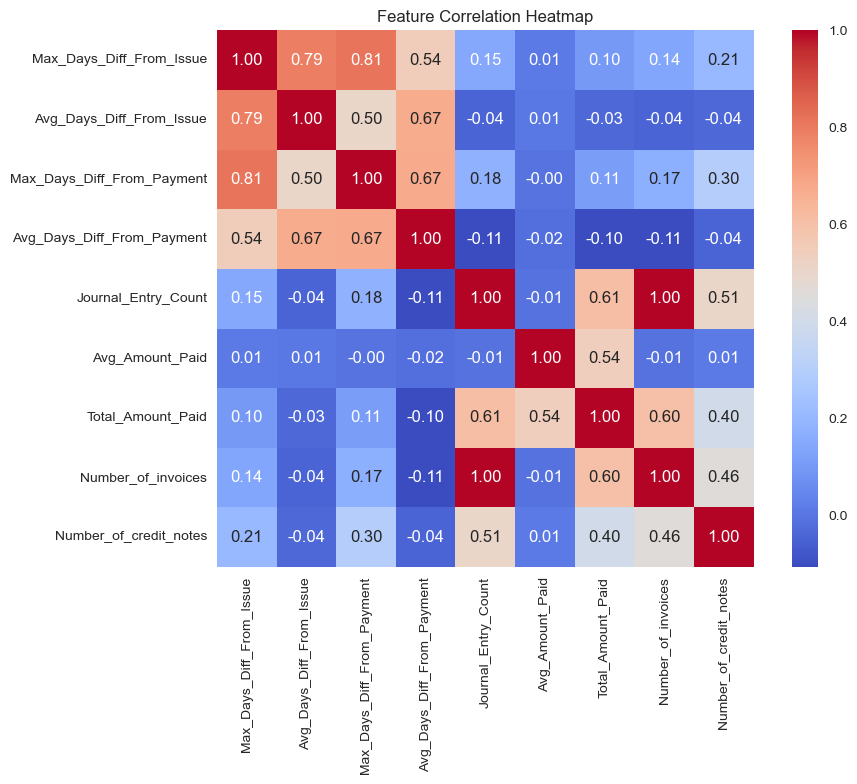

In [39]:
# Corr
corr = featuresDf.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

## Scaling and relevant plots

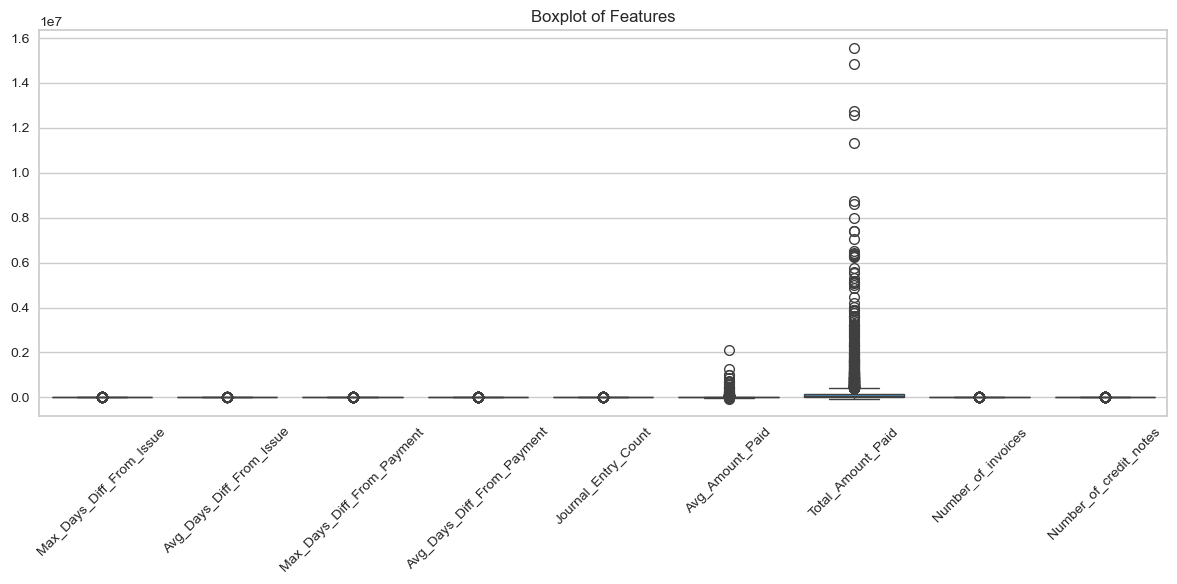

In [41]:
# Unscaled plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=featuresDf)
plt.xticks(rotation=45)
plt.title("Boxplot of Features")
plt.tight_layout()
plt.show()

In [42]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(featuresDf)
X_scaled_df = pd.DataFrame(X_scaled, columns=featuresDf.columns)

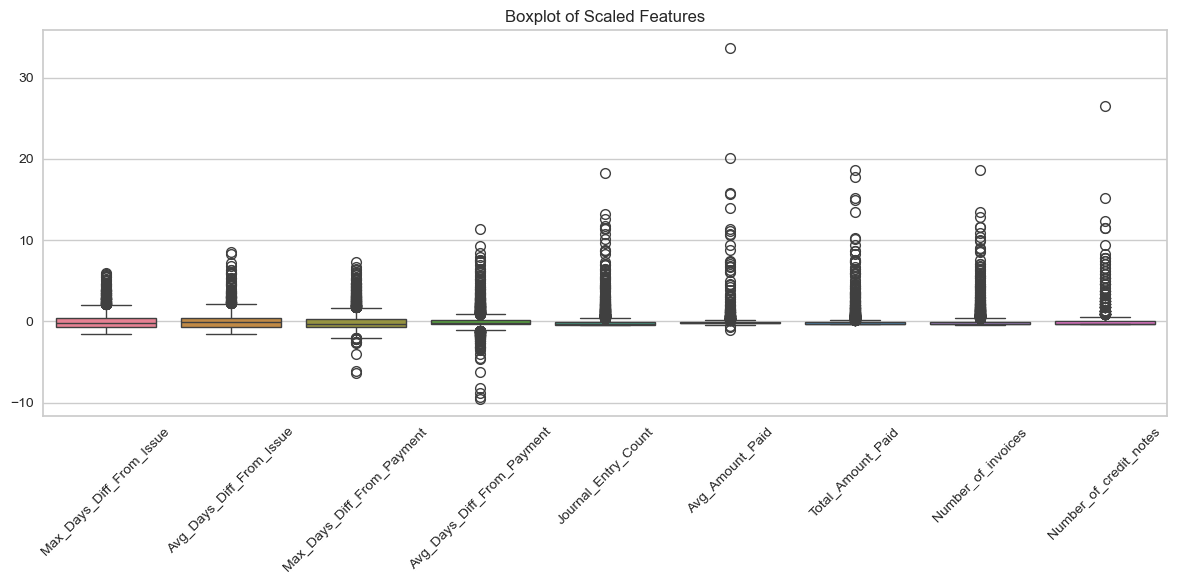

In [43]:
# Scaled plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=X_scaled_df)
plt.xticks(rotation=45)
plt.title("Boxplot of Scaled Features")
plt.tight_layout()
plt.show()

# ML

## Optimal K

In [46]:
Sum_of_squared_distances = [] 
K = range(2, 20)
for k in K:
    km = KMeans(n_clusters =k)
    km = km.fit(X_scaled)
    Sum_of_squared_distances.append(km.inertia_)

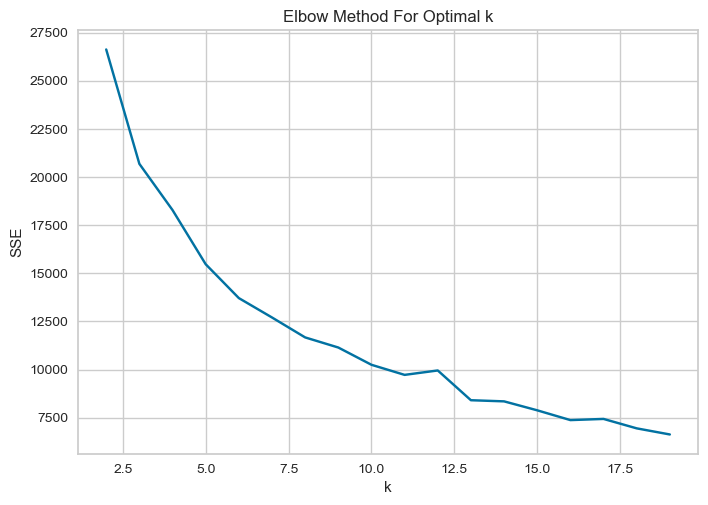

In [47]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

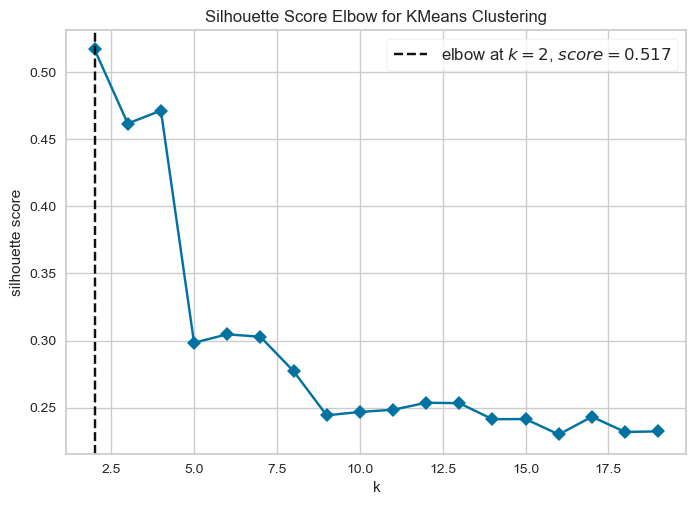

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [48]:
model = KMeans(random_state=23)
visualizer = KElbowVisualizer(model, k=(2, 20), metric='silhouette', timings=False)
visualizer.fit(X_scaled)
visualizer.show()

## Kmeans

In [50]:
opt_k = 2
kmodel = KMeans(n_clusters=opt_k, n_init=50, random_state=42)
kmodel.fit(X_scaled)
cluster_assignment = kmodel.labels_
featuresDf["KMCluster"] = cluster_assignment

## Agglomerative

In [52]:
agglomerative = AgglomerativeClustering(n_clusters=opt_k, linkage='ward')
agglomerative.fit_predict(X_scaled)
cluster_assignment = agglomerative.labels_
featuresDf["HCACluster"] = cluster_assignment

## Final output

In [111]:
outputdf = pd.concat([identifiers, featuresDf], axis=1).reset_index(drop=True)
outputdf.iloc[:, 2:] = outputdf.iloc[:, 2:].astype('float64')
outputdf.to_excel(pathout +'/output.xlsx', index = False)

In [112]:
outputdf.head()

,Key,Customer Name,Max_Days_Diff_From_Issue,Avg_Days_Diff_From_Issue,Max_Days_Diff_From_Payment,Avg_Days_Diff_From_Payment,Journal_Entry_Count,Avg_Amount_Paid,Total_Amount_Paid,Number_of_invoices,Number_of_credit_notes,KMCluster,HCACluster
0,OTHERS_I8032,RECLAYM LTD,197.0,94.600000,167.0,70.850000,20.0,21951.593264,439031.865282,16.0,4.0,0.0,0.0
1,PMEMEA_10000030,TERREAL Comptabilité coûts et actifs,66.0,63.000000,0.0,-0.333333,3.0,13061.600000,39184.800000,3.0,0.0,1.0,0.0
2,PMEMEA_10000031,BMI GROUP OPERATION MONIER,106.0,28.250000,32.0,-21.500000,4.0,120.600000,482.400000,3.0,1.0,1.0,0.0
3,PMEMEA_10000032,GEBERIT PRODUCTION,92.0,24.888889,62.0,3.962963,27.0,9272.098148,250346.650000,19.0,8.0,1.0,0.0
4,PMEMEA_10000033,CERADEL SOCOR,73.0,61.261905,61.0,6.976190,42.0,18197.384762,764290.160000,40.0,2.0,1.0,0.0
